In [1]:
import numpy as np
import sdeint
import os

import matplotlib as mpl
from matplotlib import gridspec, rc

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection


rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'


figdir = 'figs'

In [2]:
######some functions##############
def pot(x,a):
    x2 = x*x
    return x2*x2/2 - x2/4 - a*x

def jac(a):
    k = lambda x,t: -(2*x**3-x/2-a)
    return k

#stolen from: https://stackoverflow.com/questions/47163796/using-colormap-with-annotate-arrow-in-matplotlib
def rainbowarrow(ax, start, end, cmap="viridis", n=50,lw=3):
    cmap = plt.get_cmap(cmap,n)
    # Arrow shaft: LineCollection
    x = np.linspace(start[0],end[0],n)
    y = np.linspace(start[1],end[1],n)
    points = np.array([x,y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, linewidth=lw,clip_on=False)
    lc.set_array(np.linspace(0,1,n))
    ax.add_collection(lc,autolim=False)
    # Arrow head: Triangle
    tricoords = [(0,-0.4),(0.5,0),(0,0.4),(0,-0.4)]
    angle = np.arctan2(end[1]-start[1],end[0]-start[0])
    rot = mpl.transforms.Affine2D().rotate(angle)
    tricoords2 = rot.transform(tricoords)
    tri = mpl.path.Path(tricoords2, closed=True)
    ax.scatter(end[0],end[1], c=1, s=(2*lw)**2, marker=tri, cmap=cmap,vmin=0,clip_on=False)
    #ax.autoscale_view()

In [3]:
############################################
######## the simulation ####################
############################################
np.random.seed(8675307)
print('running simulation')
g     = lambda x, t: 0.25 # noise scale i assume...
tspan = np.linspace(0.0, 50, 501)
x0s   = np.random.uniform(-1,1,20)
a1s   = np.array([-1,0,1])
trajs = np.array([[sdeint.itoint(jac(a1), g, x0, tspan) for x0 in x0s] for a1 in a1s])
xfs   = trajs[:,:,-1,0]
print('making figure')

running simulation
making figure


In [4]:
############################################
######### some TeX ########################
###########################################

ctxt = r'$\mathbf{C}='+\
r'\setlength\arraycolsep{-1pt}'+\
r'\setlength{\thickmuskip}{-1mu}'+\
r'\setlength{\thinmuskip}{0mu}'+\
r'\setlength{\medmuskip}{0mu}'+\
r'\begin{pmatrix}'+\
r'\sigma(g_1) & {\rm cov}(g_1,g_2) &\cdots \\'+ \
r'\vdots & \ddots& & \\'+\
r'{\rm cov}(g_n,g_1)&  \cdots& \sigma(g_n)'+\
r'\end{pmatrix}$'

jtxt = r'$\mathbf{J}='+\
r'\setlength\arraycolsep{2pt}'+\
r'\setlength{\thinmuskip}{0mu}'+\
r'\setlength{\thickmuskip}{0mu}'+\
r'\setlength{\medmuskip}{0mu}'+\
r'\begin{pmatrix}'+\
r'\frac{\partial\dot{g}_1}{\partial g_1}& \frac{\partial\dot{g}_1}{\partial g_2}& ... \\'+\
r'\vdots & \ddots & \\'+\
r'\frac{\partial\dot{g}_n}{\partial g_1}&  & \frac{\partial\dot{g}_n}{\partial g_n}'+\
r'\end{pmatrix}$' #\Bigg\rvert_{\vec{g}^*} $'


mulens = r'\setlength{\thickmuskip}{-1mu}\setlength{\thinmuskip}{0mu}\setlength{\medmuskip}{0mu}'
modtxt  = mulens + r'$\dot{\vec{g}}=\vec{F}(\vec{g})=\vec{F}(\vec{g}^*+\overrightarrow{\delta g})\approx\mathbf{J}\overrightarrow{\delta g}$'
mulens2 = r'\setlength{\thickmuskip}{0mu}\setlength{\thinmuskip}{1mu}\setlength{\medmuskip}{1mu}'

modtxt  = mulens2+r'\begin{align*}'+\
r'\dot{\vec{g}}=\vec{F}(\vec{g})&=\vec{F}(\vec{g}^*+\overrightarrow{\delta g})\nonumber\\[-0.25em]'+\
r'&\approx\mathbf{J}\overrightarrow{\delta g}\nonumber'+\
r'\end{align*}'

disctxt = mulens + r'$\overrightarrow{\delta g}\rightarrow\overrightarrow{\delta g}+\Delta t\mathbf{J}\overrightarrow{\delta g}+\sqrt{\Delta t}\vec{\zeta}^i_t$'

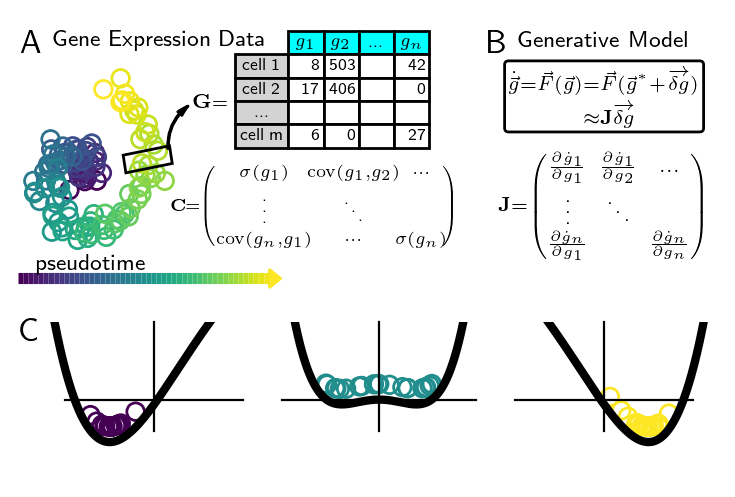

In [10]:
###########################################
############ the figure ##################
##########################################
plt.style.reload_library()
plt.style.use('one_col_fig')


marg_ht  = 1
spc_ht   = 5
pot_ht   = 14
b_ht     = 21

marg_wd = 2
t_wd    = 20

# row heights
hts = np.array([
    marg_ht,
    b_ht,
    spc_ht,
    pot_ht,
])

wds = np.array([
    marg_wd,
    t_wd,
    t_wd,
    t_wd
])

rs = np.cumsum(hts) # starting rows
cs = np.cumsum(wds) # starting cols

nr = np.sum(hts)
nc = np.sum(wds)

wid = 11.4/2.54
ht  = wid*nr/nc

fig = plt.figure(figsize=(wid, ht), dpi=200)

gs   = gridspec.GridSpec(nr, nc)

tcs0 = [cs[0], cs[1], cs[2]]
tcsF = [cs[1], cs[2], cs[3]]

axA   = plt.subplot( gs[rs[0]:rs[1], 0:cs[2]])      #  covariance
axB   = plt.subplot( gs[rs[0]:rs[1], cs[2]:cs[3]])      #  Jacobian
axC   = [plt.subplot( gs[rs[2]:rs[3],tcs0[i]:tcsF[i]]) for i in range(3)] # potentials

#####################################
############ CAPTIONS   #############
#####################################
xs = [0,-0.5,0]
ys = [-2.5,-2.5,-7]
caps  = ['A','B','C']
ri = [0,0,rs[1]]
ci = [0,cs[2],0]
for i in range(len(caps)):
    cap_ax=plt.subplot(gs[ri[i]:ri[i]+1,ci[i]:ci[i]+1])
    cap_ax.text(s=caps[i],x=xs[i],y=ys[i],fontsize=12,clip_on=False,zorder=5)
    cap_ax.axis('off')

#####################################
########## A1: "tsne" ###############
#####################################
np.random.seed(3)

nc = 2
nt = 60
ts = np.linspace(0,5,nt)

cellcols = np.repeat(plt.cm.viridis(np.linspace(0,1,nt)),nc,axis=0)#[:nt*nc]

xts = ts*np.cos(1.5*ts)
yts = ts*np.sin(1.5*ts)

noise = 0.5

xs = np.array([xt+np.random.normal(scale=noise, size=nc) for xt in xts]).reshape(-1)
ys = np.array([yt+np.random.normal(scale=noise, size=nc) for yt in yts]).reshape(-1)


axA.scatter(xs,ys,s=40, edgecolor=cellcols, facecolor='none',linewidth=1,clip_on=False)
axA.set_xlim(-4,26)
axA.set_ylim(-5,8)

#axA.axis('off')

# legend
y0 = -5.75
#dy = -5.5
dx = 15
rainbowarrow(axA, [np.amin(xs)-1,y0],[np.amin(xs)+dx,y0], cmap="viridis", n=50,lw=4)
arrtxt = 'pseudotime' #r$'\tau'$
axA.text(s=arrtxt,x=np.mean(xs),y=y0+1.25,
          verticalalignment='top',horizontalalignment='center',fontsize=8)

# rectangle zoom in
rectx, recty, rectdx, rectdy, rectth = 2.75,0.1,3,1.,10
myrect = mpatches.Rectangle((rectx,recty),rectdx,rectdy, facecolor='None',edgecolor='k',clip_on=False,
                           linewidth=1, angle=rectth)
axA.add_artist(myrect)


#####################################
######## A2: gene expr / cov   ######
#####################################

cell_text = np.array([['8','503','','42'],
                    ['17','406','','0'],
                    ['','','',''],
                    ['6','0','','27']
                   ])
rowlabs = ['cell 1','cell 2', '...','cell m']
collabs = ['gene 1','gene 2', '...','gene n']
collabs = [r'$g_1$',r'$g_2$', '...',r'$g_n$']

the_table = axA.table(cellText=cell_text,
                      rowLabels=rowlabs,
                       rowColours=['lightgray']*len(rowlabs),
                       colColours=['aqua']*len(collabs),
                      colLabels=collabs,
                      colWidths=[0.05,0.05,0.05,0.05],
                      bbox=[0.57,0.5,0.3,0.5],
                      rowLoc='center',
                      colLoc='center'

                     )
the_table.auto_set_font_size(False)
the_table.set_fontsize(6)
#the_table.set_fontsize(15)

table_props = the_table.properties()
table_cells = table_props['children']
for cell in table_cells:
    cell.set_height(0.1)

axA.axis('off')

axA.text(s=ctxt,x=0.32,y=0.25,fontsize=6,verticalalignment='center',horizontalalignment='left', 
         transform=axA.transAxes)

gtxtx,gtxty = 7,4
gtxt = axA.text(s=r'$\mathbf{G}$=',x=gtxtx,y=gtxty,fontsize=7,
         horizontalalignment='left',verticalalignment='center')
dattitle = 'Cellular Gene\nExpression'
dattitle = 'Gene Expression Data'
axA.text(s=dattitle,x=0.07,y=1,fontsize=8,
         horizontalalignment='left',verticalalignment='top', transform=axA.transAxes)

style = "Simple, tail_width=0.25, head_width=2, head_length=4"
kw = dict(arrowstyle=style, color="k")
arr = mpatches.FancyArrowPatch((rectx-rectdx*np.cos(rectth)+0.2, recty-rectdy*np.sin(rectth)+0.5),
                               (gtxtx, gtxty),
                             connectionstyle="arc3,rad={0}".format(-0.1*np.pi), **kw)
axA.add_artist(arr)


#####################################
###### B: GENERATIVE MODEL   ########
#####################################
axB.axis('off')
modtitle = 'Generative Dynamics'
modtitle = 'Generative Model'
props    = dict(boxstyle='round,pad=0.2', facecolor='white', alpha=1)

axB.text(s=modtitle,x=0.5,y=1,fontsize=8,
         horizontalalignment='center',verticalalignment='top')
axB.text(s=modtxt, x=0.5,y=0.72,fontsize=7,
         horizontalalignment='center',verticalalignment='center',bbox=props)
#axB.text(s=disctxt,x=0.5,y=0.65,fontsize=6,
#         horizontalalignment='center',verticalalignment='center')

axB.text(s=jtxt,x=0.5,y=0.25,fontsize=7,verticalalignment='center',horizontalalignment='center')


#####################################
## C: potentials   ####
#####################################
xrng = np.linspace(-2,2,1001)

xlim0 = np.array([-1.5,0.5])
xwd = (np.diff(xlim0)/2.)[0]*1.5
xlims = np.array([xlim0,np.array([-xwd,xwd]),np.flip(-xlim0)])
ylims = np.array([[-1,0],[-0.5,0.5],[-1,0]])

uoffs = np.array([0.1,0.1,0.1])

for i in range(3):
    ax  = axC[i]
    ax.plot(xrng,pot(xrng,a1s[i]), lw=3, c='k')
    dps = xfs[i,:20]

    ax.scatter(dps,pot(dps,a1s[i])+uoffs[i], s=40, edgecolor=cellcols[int(i*(len(cellcols)-1)/2)], facecolor='none',linewidth=1)
    #ax.axis('off')



    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    ax.spines['left'].set_bounds(ylims[i,0]+0.3,ylims[i,1])
    ax.spines['bottom'].set_bounds(xlims[i,0]+0.2,xlims[i,1]-0.2)

    # Eliminate upper and right axCs
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_ylim(*(ylims[i]))
    ax.set_xlim(*(xlims[i]))

os.makedirs(figdir, exist_ok=True)
plt.show()
#plt.savefig('{0}/fig2_model_data.pdf'.format(figdir), bbox_inches='tight')

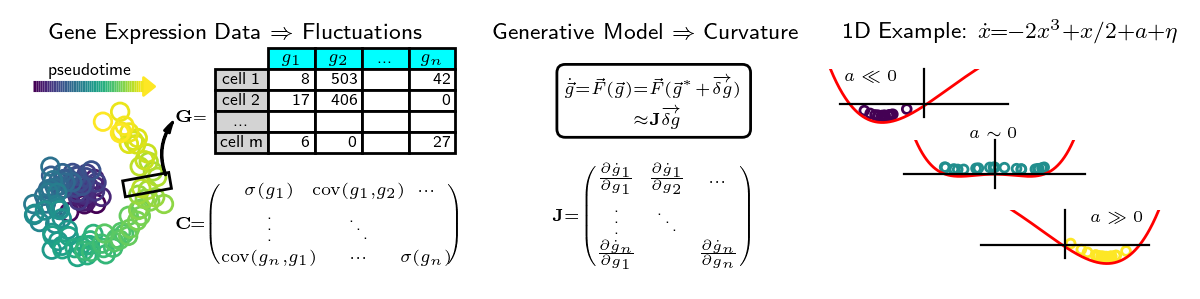

In [108]:
# same thing but one line...

###########################################
############ the figure ##################
##########################################
plt.style.reload_library()
plt.style.use('one_col_fig')


marg_ht  = 0.75
c1_ht    = 1.5

marg_wd = 1
a_wd = 9
b_wd = 7
c1_wd = 1.5

# row heights
hts = np.array([
    marg_ht,
    c1_ht,
    c1_ht,
    c1_ht,
])

wds = np.array([
    marg_wd,
    a_wd,
    b_wd,
    c1_wd,
    c1_wd,
    c1_wd,
    c1_wd,
    c1_wd,
    c1_wd
])
fac = 4
hts = np.array(hts*fac, dtype='int')
wds = np.array(wds*fac, dtype='int')
rs = np.cumsum(hts) # starting rows
cs = np.cumsum(wds) # starting cols

nr = np.sum(hts)
nc = np.sum(wds)

wid = 11.4/2.54
wid = 20./2.54
ht  = wid*nr/nc

fig = plt.figure(figsize=(wid, ht), dpi=200)

gs   = gridspec.GridSpec(nr, nc)

tcs0 = [cs[0], cs[1], cs[2]]
tcsF = [cs[1], cs[2], cs[3]]

axA   = plt.subplot( gs[rs[0]:rs[3], 0:cs[1]])      #  covariance
axB   = plt.subplot( gs[rs[0]:rs[3], cs[1]:cs[2]])      #  Jacobian
axC   = [plt.subplot( gs[rs[i]:rs[i+1], cs[2+i]:cs[5+i]]) for i in range(3)] # potentials

#####################################
############ CAPTIONS   #############
#####################################
xs = [-0.5,-2,-0.5]
xcap = [3,0.25,2.5]

ys = [0,0,0]
caps  = ['A','B','C']
ri = [0,0,0]
ci = [0,cs[1],cs[2]]

sys_eqn = mulens+r'$\dot{x}=-2x^3+x/2+a +\eta$'

cap_ttls = [r'Gene Expression Data $\Rightarrow$ Fluctuations',
            r'Generative Model $\Rightarrow$ Curvature',
           r'1D Example: '+sys_eqn]
# axC[0].text(s=sys_eqn,x=0.5,y=1,fontsize=6,
#          horizontalalignment='left',verticalalignment='top',
#             transform=axC[0].transAxes)
for i in range(len(caps)):
    cap_ax=plt.subplot(gs[ri[i]:ri[i]+1,ci[i]:ci[i]+1])
    #cap_ax.text(s=caps[i],x=xs[i],y=ys[i],fontsize=12,clip_on=False,zorder=5)
    cap_ax.text(s=cap_ttls[i],x=xcap[i],y=0,fontsize=8,
         horizontalalignment='left',verticalalignment='bottom')
    cap_ax.axis('off')

# #####################################
# ########## A1: "tsne" ###############
# #####################################
np.random.seed(3)

nc = 2
nt = 60
ts = np.linspace(0,5,nt)

cellcols = np.repeat(plt.cm.viridis(np.linspace(0,1,nt)),nc,axis=0)#[:nt*nc]

xts = ts*np.cos(1.5*ts)
yts = ts*np.sin(1.5*ts)

noise = 0.5

xs = np.array([xt+np.random.normal(scale=noise, size=nc) for xt in xts]).reshape(-1)
ys = np.array([yt+np.random.normal(scale=noise, size=nc) for yt in yts]).reshape(-1)


axA.scatter(xs,ys,s=40, edgecolor=cellcols, facecolor='none',linewidth=1,clip_on=False)
axA.set_xlim(-4,26)
axA.set_ylim(-5,8)

#axA.axis('off')

# legend
y0 = 7 #-5.75
#dy = -5.5
dx = 7
rainbowarrow(axA, [np.amin(xs),y0],[np.amin(xs)+dx,y0], cmap="viridis", n=50,lw=4)
arrtxt = 'pseudotime' #r$'\tau'$
axA.text(s=arrtxt,x=np.mean(xs),y=y0+1.35,
          verticalalignment='top',horizontalalignment='center',fontsize=6)

# rectangle zoom in
rectx, recty, rectdx, rectdy, rectth = 2.75,0.1,3,1.,10
myrect = mpatches.Rectangle((rectx,recty),rectdx,rectdy, facecolor='None',edgecolor='k',clip_on=False,
                           linewidth=1, angle=rectth)
axA.add_artist(myrect)


#####################################
######## A2: gene expr / cov   ######
#####################################

cell_text = np.array([['8','503','','42'],
                    ['17','406','','0'],
                    ['','','',''],
                    ['6','0','','27']
                   ])
rowlabs = ['cell 1','cell 2', '...','cell m']
collabs = ['gene 1','gene 2', '...','gene n']
collabs = [r'$g_1$',r'$g_2$', '...',r'$g_n$']

the_table = axA.table(cellText=cell_text,
                      rowLabels=rowlabs,
                       rowColours=['lightgray']*len(rowlabs),
                       colColours=['aqua']*len(collabs),
                      colLabels=collabs,
                      colWidths=[0.1,0.1,0.1,0.1],
                      bbox=[0.53,0.6,0.4,0.5],
                      rowLoc='center',
                      colLoc='center'

                     )
the_table.auto_set_font_size(False)
the_table.set_fontsize(6)
#the_table.set_fontsize(15)

table_props = the_table.properties()
table_cells = table_props['children']
for cell in table_cells:
    cell.set_height(0.1)

axA.axis('off')


gtxtx,gtxty = 6,5
gtxt = axA.text(s=r'$\mathbf{G}$=',x=gtxtx,y=gtxty,fontsize=6,
         horizontalalignment='left',verticalalignment='center')
axA.text(s=ctxt,x=gtxtx,y=-1.6,fontsize=6,verticalalignment='center',horizontalalignment='left')#, 
         #transform=axA.transAxes)

#dattitle = 'Cellular Gene\nExpression'

style = "Simple, tail_width=0.25, head_width=2, head_length=4"
kw = dict(arrowstyle=style, color="k")
arr = mpatches.FancyArrowPatch((rectx-rectdx*np.cos(rectth)+0.2, recty-rectdy*np.sin(rectth)+0.5),
                               (gtxtx, gtxty),
                             connectionstyle="arc3,rad={0}".format(-0.1*np.pi), **kw)
axA.add_artist(arr)


#####################################
###### B: GENERATIVE MODEL   ########
#####################################
axB.axis('off')
modtitle = 'Generative Dynamics'
props    = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=1)

axB.text(s=modtxt, x=0.5,y=0.85,fontsize=6,
         horizontalalignment='center',verticalalignment='center',bbox=props)
#axB.text(s=disctxt,x=0.5,y=0.65,fontsize=6,
#         horizontalalignment='center',verticalalignment='center')

axB.text(s=jtxt,x=0.5,y=0.3,fontsize=6,verticalalignment='center',horizontalalignment='center')


#####################################
## C: potentials   ####
#####################################
xrng = np.linspace(-2,2,1001)

xlim0 = np.array([-1.5,0.5])
xwd = (np.diff(xlim0)/2.)[0]*1.5
xlims = np.array([xlim0,np.array([-xwd,xwd]),np.flip(-xlim0)])
ylims = np.array([[-1,0],[-0.5,0.5],[-1,0]])

uoffs = np.array([0.1,0.1,0.1])

#sys_eqn = mulens+r'$\dot{x}=-2x^3+x/2+a +\eta$'
#axC[0].text(s=sys_eqn,x=0.5,y=1,fontsize=6,
#         horizontalalignment='left',verticalalignment='top',
#            transform=axC[0].transAxes)

param_strs = [r'$a\ll0$',r'$a\sim0$',r'$a\gg0$']
horiz_a = ['left','center','right']
xcap = [0.25,0.5,0.75]
ycap = [1,1.2,1]

for i in range(3):
    ax  = axC[i]
    ax.plot(xrng,pot(xrng,a1s[i]), lw=1, c='red')
    dps = xfs[i,:20]
    ax.text(s=param_strs[i],x=xcap[i],y=ycap[i], fontsize=6, ha='center',va='top',transform=ax.transAxes)
    ax.scatter(dps,pot(dps,a1s[i])+uoffs[i], s=10, edgecolor=cellcols[int(i*(len(cellcols)-1)/2)], 
               facecolor='none',linewidth=1)
    #ax.axis('off')



    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    ax.spines['left'].set_bounds(ylims[i,0]+0.3,ylims[i,1])
    ax.spines['bottom'].set_bounds(xlims[i,0]+0.2,xlims[i,1]-0.2)

    #ax.spines['left'].set_color('gray')
    #ax.spines['bottom'].set_color('gray')

    # Eliminate upper and ri ght axCs
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_ylim(*(ylims[i]))
    ax.set_xlim(*(xlims[i]))

# os.makedirs(figdir, exist_ok=True)
plt.savefig('{0}/fig2_model_data_1line.pdf'.format(figdir), bbox_inches='tight')
plt.show()


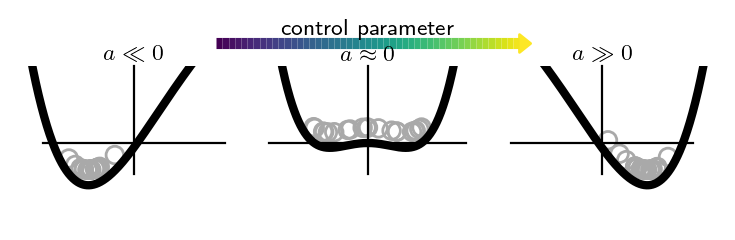

In [7]:
# just 2c
fig,axC = plt.subplots(1,3,figsize=(wid,1),dpi=200)
#####################################
## C: potentials   ####
#####################################
xrng = np.linspace(-2,2,1001)

xlim0 = np.array([-1.5,0.5])
xwd = (np.diff(xlim0)/2.)[0]*1.5
xlims = np.array([xlim0,np.array([-xwd,xwd]),np.flip(-xlim0)])
ylims = np.array([[-1,0],[-0.5,0.5],[-1,0]])

uoffs = np.array([0.1,0.1,0.1])
ttls = [r'$a\ll 0$',r'$a\approx 0$',r'$a\gg 0$']
for i in range(3):
    ax  = axC[i]
    ax.plot(xrng,pot(xrng,a1s[i]), lw=3, c='k')
    dps = xfs[i,:20]

    ax.scatter(dps,pot(dps,a1s[i])+uoffs[i], s=40, 
               edgecolor='darkgray',
               #edgecolor=cellcols[int(i*(len(cellcols)-1)/2)], 
               facecolor='none',linewidth=1)
    #ax.axis('off')



    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    ax.spines['left'].set_bounds(ylims[i,0]+0.3,ylims[i,1])
    ax.spines['bottom'].set_bounds(xlims[i,0]+0.2,xlims[i,1]-0.2)

    # Eliminate upper and right axCs
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_ylim(*(ylims[i]))
    ax.set_xlim(*(xlims[i]))
    ax.set_title(ttls[i])
# legend
y0 = -5.75
#dy = -5.5
dx = 15
rainbowarrow(axC[1], [-2,0.65],[2,0.65], cmap="viridis", n=50,lw=4)
arrtxt = 'control parameter' #r$'\tau'$
axC[1].text(s=arrtxt,x=0,y=0.8,
          verticalalignment='top',horizontalalignment='center',fontsize=8)
    
plt.subplots_adjust(wspace=0.03)



os.makedirs(figdir, exist_ok=True)
plt.show()
#plt.savefig('{0}/fig2C.jpg'.format(figdir), bbox_inches='tight')

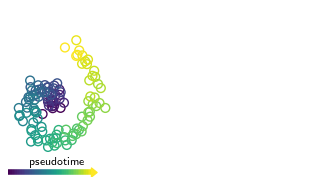

In [18]:
#####################################
########## A1: "tsne" ###############
#####################################
np.random.seed(3)

nc = 2
nt = 60
ts = np.linspace(0,5,nt)

cellcols = np.repeat(plt.cm.viridis(np.linspace(0,1,nt)),nc,axis=0)#[:nt*nc]

xts = ts*np.cos(1.5*ts)
yts = ts*np.sin(1.5*ts)

noise = 0.5

xs = np.array([xt+np.random.normal(scale=noise, size=nc) for xt in xts]).reshape(-1)
ys = np.array([yt+np.random.normal(scale=noise, size=nc) for yt in yts]).reshape(-1)

fig,axA = plt.subplots(figsize=(4,2))
axA.scatter(xs,ys,s=40, edgecolor=cellcols, facecolor='none',linewidth=1,clip_on=False)
axA.set_xlim(-4,26)
axA.set_ylim(-5,8)

#axA.axis('off')

# legend
y0 = -5.75
#dy = -5.5
dx = 7
rainbowarrow(axA, [np.amin(xs)-1,y0],[np.amin(xs)+dx,y0], cmap="viridis", n=50,lw=4)
arrtxt = 'pseudotime' #r$'\tau'$
axA.text(s=arrtxt,x=np.mean(xs),y=y0+1.25,
          verticalalignment='top',horizontalalignment='center',fontsize=8)

axA.axis('off')

# # rectangle zoom in
# rectx, recty, rectdx, rectdy, rectth = 2.75,0.1,3,1.,10
# myrect = mpatches.Rectangle((rectx,recty),rectdx,rectdy, facecolor='None',edgecolor='k',clip_on=False,
#                            linewidth=1, angle=rectth)
#axA.add_artist(myrect)
plt.show()


In [ ]:
fig,axs=plt.subplots(2,1)